# Valuation of Energy Storage: Implementation of Example 3.4 of Bachouch et al. arXiv:1812.05916


From [arXiv page](https://arxiv.org/abs/1812.05916):
"We consider a commodity (gas) that has to be stored in a cave, e.g. salt domes or aquifers. The manager of such a cave aims to maximize the real options value by optimizing over a finite horizon N the dynamic decisions to inject or withdraw gas as time and market conditions evolve."


Please notice that the ReadTheDocs env has trouble rendering the math displays.
The notebook is rendered correctly at its [github location](https://github.com/rbosh/ml-adp/blob/master/doc/source/examples/energy_storage.ipynb).

$(P_t)_{t=0,\dots, T}$ the gas price, with $$P_{t+1} = \bar{p}(1-\beta) + \beta P_t + \xi_{t+1}$$ where $\bar{p} = 5$ the stationary value of the gas price, $\beta=0.5$ the rate of mean-reversal, and $\xi_{t+1}\sim \mathcal{N}(0, 0.05)$.

"The current inventory in the gas storage is denoted by $(C^\alpha_t)_t$ and depends on the manager’s decisions represented by a control process $\alpha = (\alpha_t)$ valued in $\{−1, 0, 1\}$: 
$\alpha_t = 1$ (resp. $−1$) means that she injects (resp. withdraws) gas with an injection (resp. withdrawal) rate $a_{in}(C^\alpha_t)$ (resp. $a_{out}(C^\alpha_t))$ requiring (causing) a purchase (resp. sale) of $b_{in}(C^\alpha_t) \geq a_{in}(C^\alpha_t)$ (resp. $b_{out}(C^\alpha_t) \leq a_{out}(C^\alpha_t))$, and $\alpha_t = 0$ means that she is doing nothing. The difference between $b_{in}$ and $a_{in}$ (resp. $b_{out}$ and $a_{out}$) indicates gas loss during injection/withdrawal. The evolution of the inventory is then governed by $$C^\alpha_{t+1} = C^{\alpha}_{t} + h(C^\alpha_t , \alpha_t),\quad t = 0, . . . , T − 1, \quad  C^\alpha_0 = c_0$$ where we set $h(c, a) = a_{in}(c)$ if $a=1$, $h(c,a)=-a_{out}(c)$ if $a=-1$, and $h(c,a)=0$ if $a=0$."
We set $a_{in} = 0.06 = b_{in}$ and $a_{out} = 0.25 = b_{out}$.

We have the physical inventory constraint $$C^\alpha_t \in [C_{min}, C_{max}]$$ where $C_{min} = 0$ and $C_{max} = 8$.

The time-$t$ cost (for $t< T$) of the manager is $$K_t(p, c, a) = \begin{cases} b_{in}(c)p + k c, & a=1\\ kc, & a=0\\ b_{out}(c)p + kc, & a=-1\end{cases}$$ where $k=0.01$ is the storage cost, while $$K_T(p, c) = \mu P (c_0 - c)$$ penalizes shortfall at final time below the initial level of inventory ($\mu=2$).

In [1]:
steps = 5

stationary_price = 5.
reversal_rate = .5

storage_cost_rate = 0.01

initial_inventory = 4.

penalty_factor = 2.

a_in, a_out = 0.06, 0.25
b_in, b_out = a_in, a_out

We make sense of states, controls and random effects as follows:
$$\mathrm{state}_t = (\mathrm{gas\_price}_t, \mathrm{inventory}_t) = (p_t, c_t)$$
$$\mathrm{control}_t = a_t$$

Implementation of state transition function (state is $s_t = (p_t, c_t)$):

In [2]:
import torch
from torch import heaviside

def _choose(x, a, b):
    return (b + a) * heaviside(x, a / (a + b)) - a


class StateTransition:
    def __init__(self, stationary_price: float = 5., reversal_rate: float = 0.5,
                 a_in: float = 0.06, a_out: float = 0.25):
        self.stationary_price = stationary_price
        self.reversal_rate = reversal_rate
        self.a_in = torch.tensor([a_in])
        self.a_out = torch.tensor([a_out])

    def __call__(self, gas_price, inventory, control, z):
        return {
            'gas_price': (self.stationary_price * (1 - self.reversal_rate)
                          + gas_price * self.reversal_rate
                          + z),
            'inventory': inventory + _choose(control, a=self.a_out, b=self.a_in)
        }

Implementation of running cost and terminal cost:

In [5]:
from torch.nn.functional import relu

class RunningCost:

    _RANGE_PENALTY_FACTOR = 1e5

    def __init__(self, storage_cost_rate: float = 0.01, b_in: float = 0.06, b_out: float = 0.25,
                 c_min: float = 0., c_max: float = 8.):
        self.storage_cost_rate = storage_cost_rate
        self.b_in = torch.tensor([b_in])
        self.b_out = torch.tensor([b_out])
        self.c_min = c_min; self.c_max = c_max

    def __call__(self, gas_price, inventory, control):
        cost = (_choose(control, a=self.b_out, b=self.b_in) * gas_price
                + self.storage_cost_rate * inventory
                + RunningCost._RANGE_PENALTY_FACTOR * relu(inventory - self.c_max)
                + RunningCost._RANGE_PENALTY_FACTOR * relu(self.c_min - inventory))

        return cost


class TerminalCost:

    _RANGE_PENALTY_FACTOR = 1e5
    _SURPLUS_PENALTY_FACTOR = 2

    def __init__(self, initial_inventory: float = 4.,
                 c_min: float = 0., c_max: float = 8.):
        self.initial_inventory = initial_inventory
        self.c_min = c_min
        self.c_max = c_max

    def __call__(self, gas_price, inventory, **kwargs):
        cost = (TerminalCost._SURPLUS_PENALTY_FACTOR * gas_price * relu(self.initial_inventory - inventory)
                + TerminalCost._RANGE_PENALTY_FACTOR * relu(inventory - self.c_max)
                + TerminalCost._RANGE_PENALTY_FACTOR * relu(self.c_min - inventory))  

        return cost


Crate StateAccumulation object of appropriate length and set state and cost functions:

In [6]:
from ml_adp import CostAccumulation

cost_accumulation = CostAccumulation.from_steps(steps)

cost_accumulation.state_functions[:-1] = StateTransition(stationary_price, reversal_rate, a_in, a_out)
cost_accumulation.cost_functions[:-1] = RunningCost(storage_cost_rate, b_in, b_out)
cost_accumulation.cost_functions[-1] = TerminalCost(initial_inventory)

cost_accumulation


CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       |         None          | <__main__.Running...>
   1  | <__main__.StateTr...> |         None          | <__main__.Running...>
   2  | <__main__.StateTr...> |         None          | <__main__.Running...>
   3  | <__main__.StateTr...> |         None          | <__main__.Running...>
   4  | <__main__.StateTr...> |         None          | <__main__.Running...>
   5  | <__main__.StateTr...> |         None          | <__main__.Termina...>
  (6) |         None          |                       |                      
)

Choose neural network based classifier control functions:
FFN with softmax activation, before choosing the action according to argmax.

In [5]:
from ml_adp.utils.fnn import FFN

class Control(torch.nn.Module):
    def __init__(self, hidden_size=(50, 50)):
        super().__init__()

        self.control_values = torch.tensor([[-1.], [0.], [1.]])
        proba_net_size = (2, *hidden_size, 3)
        self.proba_net = FFN.from_config(proba_net_size, output_activation=torch.nn.Softmax(dim=1))

    def probas(self, gas_price, inventory):
        return self.proba_net(torch.cat([gas_price, inventory], dim=1))

    def forward(self, **state):
        idx = torch.argmax(self.probas(**state), dim=1)
        return {'control': self.control_values[idx]}    

Set control functions:

In [6]:
for i in range(len(cost_accumulation) - 1):
    cost_accumulation.control_functions[i] = Control()

Inspect the object:

In [7]:
cost_accumulation

CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       | Control(          ... | <__main__.Cost ob...>
   1  | <__main__.StateTr...> | Control(          ... | <__main__.Cost ob...>
   2  | <__main__.StateTr...> | Control(          ... | <__main__.Cost ob...>
   3  | <__main__.StateTr...> | Control(          ... | <__main__.Cost ob...>
   4  | <__main__.StateTr...> | Control(          ... | <__main__.Cost ob...>
   5  | <__main__.StateTr...> |         None          | <__main__.Termina...>
  (6) |         None          |                       |                      
)

Create training state ($(\tilde{P}_t, \tilde{C}_t)$) and random effects ($(\xi_{t+1})$) samplers:

In [8]:
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform


class TrainingStateSampler:
    def __init__(self, simulation_size: int) -> None:
        self._uniform = Uniform(torch.tensor([0.0]), torch.tensor([8.0]))
        self.simulation_size = simulation_size

    def sample(self, time: int) -> torch.Tensor:
        state = {
            'gas_price': self._uniform.sample((self.simulation_size,)),
            'inventory': self._uniform.sample((self.simulation_size,))
        }
        return state


class RandomEffectSampler:
    def __init__(self, simulation_size: int) -> None:
        self._normal = Normal(torch.tensor([0.]), torch.tensor([1.]))
        self.simulation_size = simulation_size

    def sample(self, time: int) -> torch.Tensor:
        return {'z': self._normal.sample((self.simulation_size,))}


Perform backward-iterative ADP optimization following "ClassifPI algorithm" from Bachouch et al: arXiv:1812.05916

In [9]:
from tqdm import tqdm

In [10]:
simulation_size = 500
training_state_sampler = TrainingStateSampler(simulation_size)
random_effects_sampler = RandomEffectSampler(simulation_size)

cost_accumulation.train()

for time in reversed(range(cost_accumulation.steps())):
    objective = cost_accumulation[time:]

    control = objective.control_functions[0] 
    print(f"Time {time} objective:")
    print(objective)
    print(75 * "%")

    optimizer = torch.optim.AdamW(params=control.parameters(), lr=1e-4, weight_decay=1e-3)
   
    gradient_descent_iterations = tqdm(range(1000), ascii=' =')
    for iteration in gradient_descent_iterations:
        training_state = training_state_sampler.sample(time)
        random_effects = [random_effects_sampler.sample(t) for t in range(time, time + objective.steps())]

        probas = control.probas(**training_state)

        loss = 0.
        for control_idx in range(probas.size(1)):
            control_value = control.control_values[control_idx]
            objective.control_functions[0] = lambda **state: {'control': control_value.unsqueeze(0)}

            loss = loss + (objective(training_state, random_effects) * probas[:, [control_idx]]).mean()
        
        gradient_descent_iterations.set_description(
            f"Time {time} Loss: {loss:9.4f}"
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    control.eval()



Time 4 objective:
CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       | Control(          ... | <__main__.Cost ob...>
   1  | <__main__.StateTr...> |         None          | <__main__.Termina...>
  (2) |         None          |                       |                      
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 4 Loss:    8.3242: 100%|==========| 1000/1000 [00:23<00:00, 42.35it/s]


Time 3 objective:
CostAccumulation(
 time |      state_func       |     control_func      |       cost_func      
   0  |                       | Control(          ... | <__main__.Cost ob...>
   1  | <__main__.StateTr...> | Control(          ... | <__main__.Cost ob...>
   2  | <__main__.StateTr...> |         None          | <__main__.Termina...>
  (3) |         None          |                       |                      
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 3 Loss:   10.8066:  44%|====      | 445/1000 [00:13<00:16, 32.91it/s]


KeyboardInterrupt: 

Plot policies versus state using color-map scatter plot:

In [12]:
gas_prices = torch.arange(3.5, 6.0, 0.05)
inventories = torch.arange(3., 5.0, 0.05)

grid = torch.cartesian_prod(gas_prices, inventories)

x, y = grid.tensor_split(2, dim=1)

control = cost_accumulation.control_functions[0]
c = control(**{'gas_price': x, 'inventory':y })

In the following plots, yellow indicates 1 (injection) and purple indicates -1 (withdrawal).

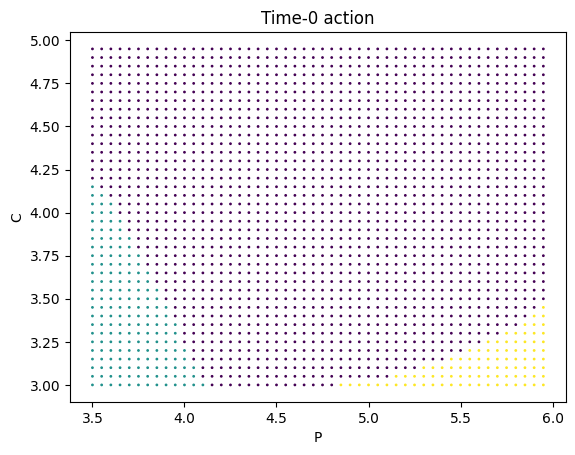

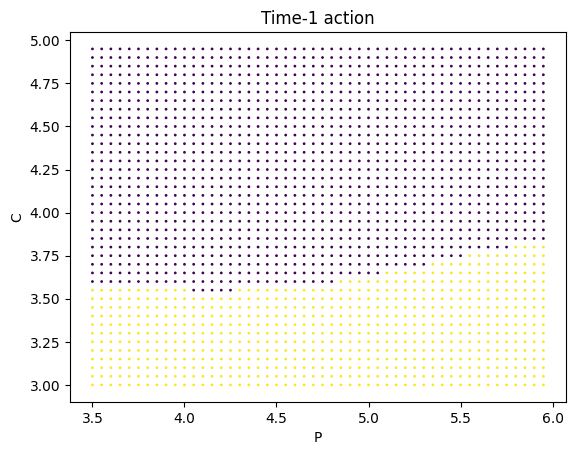

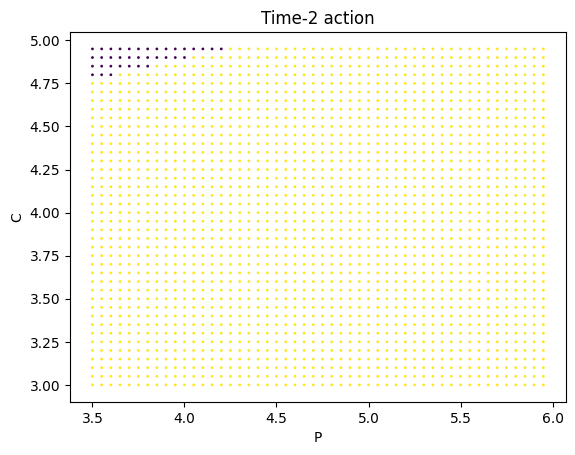

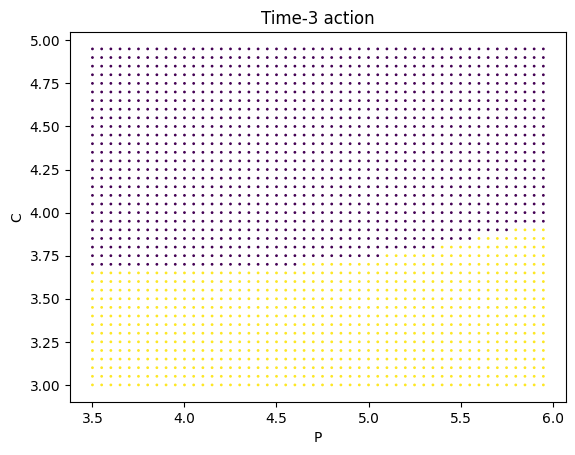

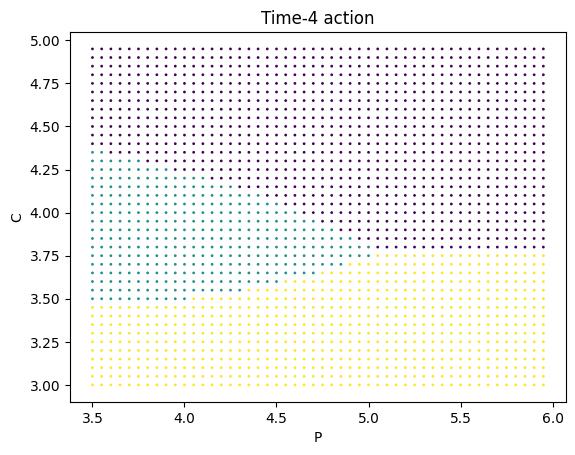

In [13]:
import matplotlib.pyplot as plt

for time, control_function in enumerate(cost_accumulation.control_functions[:-1]):
    c = control_function(**{'gas_price': x, 'inventory':y })['control']
    plt.scatter(x, y, s=1., c=c)
    plt.xlabel('P')
    plt.ylabel('C')
    plt.title(f'Time-{time} action')
    plt.show()